In [1]:
import sys
sys.path.append("/home/azhuavlev/PycharmProjects/ml-neuman_mano/pytorch3d_nerf")

%load_ext autoreload
%autoreload 2

from torch.utils.data import DataLoader
from datasets import dataset_extr_to_mano
import glob
import os
import glob
import json
import math
import matplotlib.pyplot as plt
import numpy as np
import os
import pytorch3d
import sys
import time
import torch
from tqdm import tqdm

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [2]:
# disable pytorch gradient computation
torch.set_grad_enabled(False)

%matplotlib inline

data_path = '/home/azhuavlev/Desktop/Data/InterHand_Neuman/07_cam5_im12'
all_ids = list(range(len(glob.glob(os.path.join(data_path, 'cameras', '*.json')))))

# use 80% of the data for training, randomize the order
np.random.shuffle(all_ids)

full_dataset = dataset_extr_to_mano.NeumanDataset(data_path, all_ids, bg_rm_dilation=50)

# We sample 6 random cameras in a minibatch.
batch_size = 1

full_loader = DataLoader(full_dataset, batch_size=batch_size, shuffle=False)

Fix shapedirs bug of MANO
creating zero pose silhouettes, device:  cuda
creating silhouettes, device:  cuda


images.shape torch.Size([1, 512, 334, 3])


Text(0.5, 1.0, 'Silhouette')

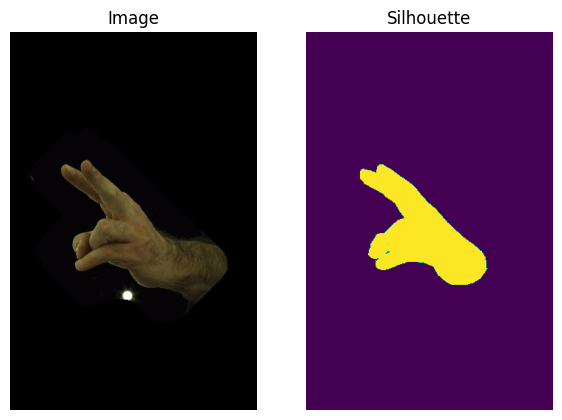

In [3]:
# get example batch
batch = next(iter(full_loader))
camera_params, images, silhouettes, silhouettes_can, manos = batch
print('images.shape', images.shape)
# plot images[0] and silhouettes[0]
plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.imshow(images[0].cpu().numpy())
plt.grid(False)
plt.axis('off')
plt.title('Image')
plt.subplot(1, 2, 2)
plt.imshow(silhouettes[0].cpu().numpy())
plt.grid(False)
plt.axis('off')
plt.title('Silhouette')

In [4]:
import segmentation.grabcut_utils as grabcut_utils

image_np = (images[0].cpu().numpy() * 255).astype(np.uint8)
silhouette_np = (silhouettes[0].unsqueeze(-1).cpu().numpy() * 255).astype(np.uint8)

# print('image_np', image_np)
# print('silhouette_np', silhouette_np)

#refine mask with grabcut
mano_mask_gc = grabcut_utils.grabcut_refine(silhouette_np, image_np)

print('mano_mask_gc', mano_mask_gc.shape)


mano_mask_gc (512, 334)


Text(0.5, 1.0, 'Silhouette_mano and Silhouette_mano_gc')

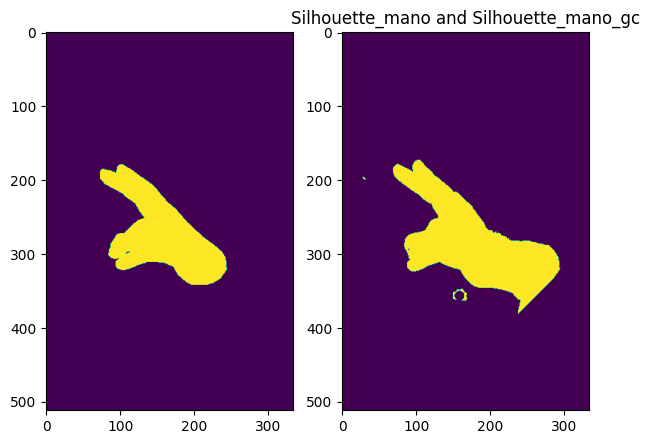

In [5]:
# plot silhouette_np and mano_mask_gc on subplots
plt.figure(figsize=(7, 7))
plt.subplot(1, 2, 1)
plt.imshow(silhouette_np[:, :, 0])
plt.grid(False)

plt.subplot(1, 2, 2)
plt.imshow(mano_mask_gc)
plt.grid(False)

plt.title('Silhouette_mano and Silhouette_mano_gc')


In [6]:
#largest component
mano_mask_gc_lc = grabcut_utils.largest_component(mano_mask_gc)

#detect forearm region in the mask (if any)
mano_mask_forearm_removed = grabcut_utils.remove_forearm(silhouette_np, mano_mask_gc_lc)

Text(0.5, 1.0, 'Silhouette_mano_gc_lc_forearm_removed')

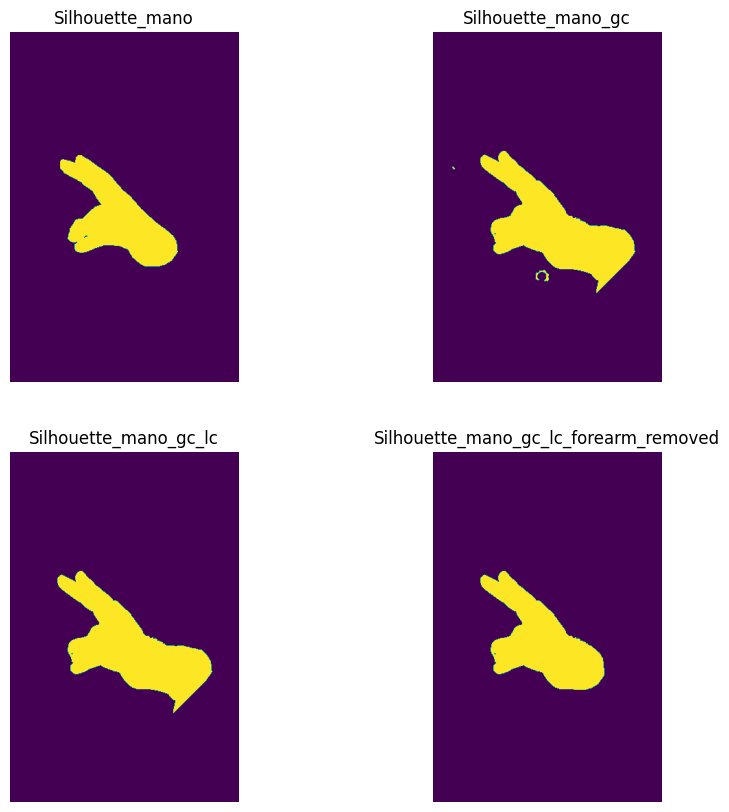

In [7]:
# plot silhouette_np, mano_mask_gc, mano_mask_gc_lc, mano_mask_forearm_removed on subplots, with titles
plt.figure(figsize=(10, 10))
plt.subplot(2, 2, 1)
plt.imshow(silhouette_np[:, :, 0])
plt.axis('off')
plt.title('Silhouette_mano')

plt.subplot(2, 2, 2)
plt.imshow(mano_mask_gc)
plt.axis('off')
plt.title('Silhouette_mano_gc')

plt.subplot(2, 2, 3)
plt.imshow(mano_mask_gc_lc)
plt.axis('off')
plt.title('Silhouette_mano_gc_lc')

plt.subplot(2, 2, 4)
plt.imshow(mano_mask_forearm_removed)
plt.axis('off')
plt.title('Silhouette_mano_gc_lc_forearm_removed')

In [8]:
mask_improved = torch.tensor(mano_mask_forearm_removed)
mask_improved = mask_improved / mask_improved.max()
print(mask_improved.shape)

torch.Size([512, 334])


In [9]:
mask_improved_3ch = mask_improved.unsqueeze(-1).repeat(1, 1, 3)
print(mask_improved_3ch.shape)

img_segmented = images[0] * mask_improved_3ch

torch.Size([512, 334, 3])


Text(0.5, 1.0, 'Image - Image_segmented')

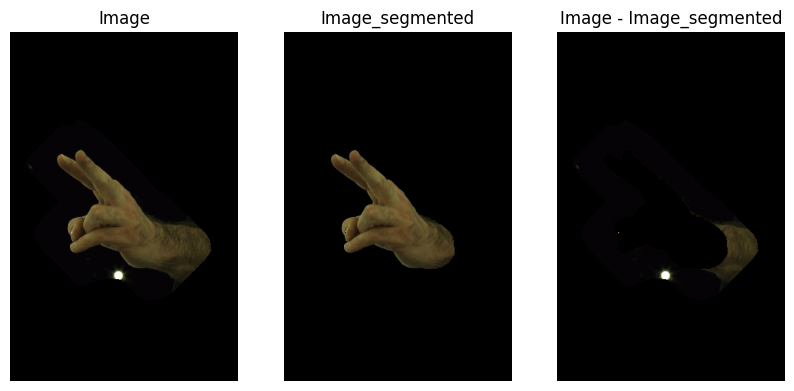

In [10]:
# plot images[0], img_segmented, and difference on subplots, with titles
plt.figure(figsize=(10, 10))
plt.subplot(1, 3, 1)
plt.imshow(images[0].cpu().numpy())
plt.axis('off')
plt.title('Image')

plt.subplot(1, 3, 2)
plt.imshow(img_segmented.cpu().numpy())
plt.axis('off')
plt.title('Image_segmented')

plt.subplot(1, 3, 3)
plt.imshow(images[0].cpu().numpy() - img_segmented.cpu().numpy())
plt.axis('off')
plt.title('Image - Image_segmented')